## Problem Description

This project is based on the Kaggle Playground Series (Season 5, Episode 8) 
Binary Classification with a Bank Dataset.

The dataset is provided in two parts:
- **Training data**, which includes both input features and the target variable `y`
- **Test data**, which contains only input features and is used for final evaluation

The task is to learn patterns from the training data and predict the probability
of subscription for each client in the test dataset.

Model performance is evaluated on Kaggle using the **ROC–AUC** metric, and results
are reported on both the **public** and **private** leaderboards.

## Dataset Description & Feature Overview

The dataset is a synthetically generated version of a real-world bank marketing dataset.
Each row represents a single client contacted during a marketing campaign, and the goal
is to predict whether the client will subscribe to a bank term deposit.

The dataset contains a mix of **demographic**, **financial**, and **campaign-related**
features, along with a binary target variable.

---

### Target Variable

- **y**
  - Binary target variable
  - `1` → Client subscribed to the term deposit  
  - `0` → Client did not subscribe
  - The target is highly imbalanced, making ROC–AUC a more appropriate evaluation metric
    than accuracy.

---

### Client Demographic Features

- **age**
  - Age of the client in years.
    
- **job**
  - Type of job (e.g., admin, technician, services, retired).

- **marital**
  - Marital status of the client (single, married, divorced).

- **education**
  - Highest education level attained.

---

### Financial Background Features

- **default**
  - Indicates whether the client has credit in default.

- **balance**
  - Average yearly account balance in euros.

- **housing**
  - Whether the client has a housing loan.

- **loan**
  - Whether the client has a personal loan.

---

### Contact & Campaign Information

- **contact**
  - Communication type used to contact the client (cellular, telephone).

- **day**
  - Last contact day of the month.

- **month**
  - Month of the last contact.

- **duration**
  - Duration of the last contact in seconds.

---

### Campaign Performance Features

- **campaign**
  - Number of contacts performed during the current campaign for the client.

- **pdays**
  - Number of days since the client was last contacted in a previous campaign.

- **previous**
  - Number of contacts performed before the current campaign.

- **poutcome**
  - Outcome of the previous marketing campaign (success, failure, unknown).

---

### Problem Characteristics

- The dataset contains **both numerical and categorical features**.
- The target variable is **imbalanced**, with far fewer positive subscriptions.
- Tree-based models such as **XGBoost** are well-suited for this data due to:
  - Ability to handle non-linear relationships
  - Robustness to feature scaling
  - Support for class imbalance via `scale_pos_weight`

---

### Objective

The objective of this project is to train a robust binary classification model
using the provided training dataset to predict the probability that a client
will subscribe to a bank term deposit.

After training, the final model is saved and used to generate probability
predictions on the unseen test dataset. These predictions are submitted to
Kaggle, where performance is evaluated using ROC–AUC and reflected through
public and private leaderboard scores.


In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s5e8/sample_submission.csv
/kaggle/input/playground-series-s5e8/train.csv
/kaggle/input/playground-series-s5e8/test.csv


In [3]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import (roc_auc_score, accuracy_score,precision_score, recall_score, f1_score,confusion_matrix, classification_report)


# Loading and Inspection of Dataset

In [4]:
# Loading the train data
df = pd.read_csv('/kaggle/input/playground-series-s5e8/train.csv')

In [5]:
df.sample(5)

,id,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
151388,151388,39,technician,single,secondary,yes,-143,yes,no,unknown,27,may,95,1,-1,0,unknown,0
9053,9053,49,admin.,married,secondary,no,48,no,yes,cellular,17,nov,612,2,-1,0,unknown,0
233538,233538,48,management,married,tertiary,no,810,no,no,cellular,6,aug,78,4,-1,0,unknown,0
331994,331994,32,admin.,single,secondary,no,3294,yes,no,telephone,20,nov,33,3,-1,0,unknown,0
621509,621509,43,housemaid,single,primary,no,664,no,no,unknown,20,jun,12,6,-1,0,unknown,0


In [6]:
# Checking the dataset whether the dataset is balanced or not
df['y'].value_counts(normalize=True)*100

y
0    87.934933
1    12.065067
Name: proportion, dtype: float64

**Nearly 88% of samples are from class 0 and 12% of samples are from class 1 . Since the dataset is not severe imbalanced. So , we will not treat it as a imbalanced data.**

In [7]:
# checking missing values
df.isna().sum()

id           0
age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
day          0
month        0
duration     0
campaign     0
pdays        0
previous     0
poutcome     0
y            0
dtype: int64

**NO Missing value found in the dataset .**

In [8]:
# Checking Duplicated Present or not
df.duplicated().sum()

np.int64(0)

**NO Duplicate Found**

In [9]:
# Numerical Features
num_cols = df.select_dtypes(include=['int64','float64']).columns.tolist()
print('Numerical Features :',num_cols)

# Categorical Columns
cat_cols = df.select_dtypes(include=['object']).columns.tolist()
print('\nCategorical Features :',cat_cols)

Numerical Features : ['id', 'age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous', 'y']

Categorical Features : ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'poutcome']


In [10]:
# Loading the test data
test_df =pd.read_csv('/kaggle/input/playground-series-s5e8/test.csv')

# Data Preprocessing

In [11]:
# Month columns mapping
month_map = {
    'jan': 1, 'feb': 2, 'mar': 3, 'apr': 4,
    'may': 5, 'jun': 6, 'jul': 7, 'aug': 8,
    'sep': 9, 'oct': 10, 'nov': 11, 'dec': 12
}
df['month'] = df['month'].map(month_map)

bin_cols = ['default' , 'housing' , 'loan']

df[bin_cols] = df[bin_cols].replace({'no':0 , 'yes':1})


/tmp/ipykernel_55/2352122973.py:11: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[bin_cols] = df[bin_cols].replace({'no':0 , 'yes':1})


In [12]:
# Month columns mapping
test_df['month'] = test_df['month'].map(month_map)

# Binary columns mapping
test_df[bin_cols] = test_df[bin_cols].replace({'no': 0, 'yes': 1})


/tmp/ipykernel_55/2040486572.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  test_df[bin_cols] = test_df[bin_cols].replace({'no': 0, 'yes': 1})


In [13]:
# Dropping the id columns from the test data
X_test_kaggle = test_df.drop(columns=['id'])


In [14]:
X = df.drop(columns=['id','y'])
y = df['y']

# Data Splitting

In [15]:
# Train test split
X_train ,X_test, y_train ,y_test = train_test_split(X , y , test_size = 0.2 , stratify = y , random_state = 42)

# Data Preprocessing and Modeling using sklearn pipeline

In [16]:
# Creating a pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

cat_cols = ['job', 'marital', 'education', 'contact', 'poutcome']
num_cols = ['age', 'balance', 'duration', 'month']

# Performing the OneHotEncoding on Categorical Features

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols),
        ('num', 'passthrough', num_cols)
    ]
)

In [17]:
# Applying the Xgboost Model
from xgboost import XGBClassifier

neg, pos = y_train.value_counts()
scale_pos_weight = neg / pos

xgb = XGBClassifier(
    n_estimators=300,
    max_depth=6,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    scale_pos_weight=scale_pos_weight,
    eval_metric='auc',
    random_state=42
)

In [18]:
from sklearn.pipeline import Pipeline

pipeline = Pipeline([
    ('prep' , preprocessor),
    ('model', xgb)
])

In [19]:
pipeline.fit(X_train , y_train)

Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['job', 'marital',
                                                   'education', 'contact',
                                                   'poutcome']),
                                                 ('num', 'passthrough',
                                                  ['age', 'balance', 'duration',
                                                   'month'])])),
                ('model',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.8, d...
                               feature_types=None, feature_weights=None,
                               gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.05,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=6, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=300, n_jobs=None,
                               num_parallel_tree=None, ...))])

## EDA & Preprocessing Strategy

The dataset contains a mix of numerical and categorical features and exhibits
class imbalance in the target variable. Instead of applying aggressive data
transformations, the preprocessing strategy was designed to align with the
strengths of tree-based models.

### Metric Selection

- **ROC–AUC** is used as the primary evaluation metric due to class imbalance.
- Accuracy is avoided, as a model can achieve high accuracy by predicting only
  the majority class while failing to identify positive subscriptions.

### Class Imbalance Handling

- The imbalance in the target variable is addressed using the
  `scale_pos_weight` parameter in XGBoost.
- This approach penalizes misclassification of the minority class more heavily
  and is preferred over resampling methods for large tabular datasets.

### Feature Scaling & Distribution

- **No feature scaling** is applied, as tree-based models such as XGBoost are
  invariant to monotonic feature transformations.
- **Outlier detection and removal** are intentionally avoided, since
  tree-based models are robust to outliers and can naturally handle skewed
  feature distributions through split-based learning.

### Rationale

This strategy reduces unnecessary preprocessing, minimizes the risk of data
leakage, and allows the model to learn non-linear relationships directly from
the raw feature space.


# Result and Analysis

In [20]:
# Probabilities
y_train_proba = pipeline.predict_proba(X_train)[:, 1]
y_test_proba  = pipeline.predict_proba(X_test)[:, 1]

print(f"Train AUC: {roc_auc_score(y_train, y_train_proba):.5f}")
print(f"Test  AUC: {roc_auc_score(y_test, y_test_proba):.5f}")

Train AUC: 0.96065
Test  AUC: 0.95835


In [21]:
from sklearn.metrics import precision_recall_curve
prec, rec, thr = precision_recall_curve(y_test, y_test_proba)
f1 = 2 * prec * rec / (prec + rec + 1e-9)
best_thr = thr[np.argmax(f1)]
best_thr

np.float32(0.7827006)

In [22]:
# Class predictions 
y_train_pred = (y_train_proba >= best_thr).astype(int)
y_test_pred  = (y_test_proba >= best_thr).astype(int)

**The default threshold of 0.5 is not optimal for imbalanced data. We select a threshold that maximizes F1-score.**


In [23]:
def print_metrics(y_true, y_pred, y_proba, name):
    print(f"\n===== {name} METRICS =====")
    print(f"AUC       : {roc_auc_score(y_true, y_proba):.5f}")
    print(f"Accuracy  : {accuracy_score(y_true, y_pred):.5f}")
    print(f"Precision : {precision_score(y_true, y_pred):.5f}")
    print(f"Recall    : {recall_score(y_true, y_pred):.5f}")
    print(f"F1-score  : {f1_score(y_true, y_pred):.5f}")
    print("\nConfusion Matrix:")
    print(confusion_matrix(y_true, y_pred))
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred))


In [24]:
print_metrics(y_train, y_train_pred, y_train_proba, "TRAIN")
print_metrics(y_test, y_test_pred, y_test_proba, "TEST")



===== TRAIN METRICS =====
AUC       : 0.96065
Accuracy  : 0.92176
Precision : 0.64871
Recall    : 0.76679
F1-score  : 0.70282

Confusion Matrix:
[[497551  30059]
 [ 16882  55508]]

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.94      0.95    527610
           1       0.65      0.77      0.70     72390

    accuracy                           0.92    600000
   macro avg       0.81      0.85      0.83    600000
weighted avg       0.93      0.92      0.92    600000


===== TEST METRICS =====
AUC       : 0.95835
Accuracy  : 0.92010
Precision : 0.64332
Recall    : 0.75809
F1-score  : 0.69601

Confusion Matrix:
[[124295   7607]
 [  4378  13720]]

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.94      0.95    131902
           1       0.64      0.76      0.70     18098

    accuracy                           0.92    150000
   macro avg       0.80      0.85      0.83   

In [25]:
test_pred = pipeline.predict_proba(X_test_kaggle)[:, 1]


In [26]:
submission = pd.DataFrame({
    'id': test_df['id'],
    'y': test_pred
})


In [27]:
# Saving csv
submission.to_csv('submission.csv', index=False)


## Baseline Model Training

An XGBoost classifier was trained using manually selected hyperparameters
and class imbalance handling via `scale_pos_weight`. The model was evaluated
using ROC–AUC and threshold-based classification metrics.

**Key Observations:**
- Strong generalization with minimal train–test AUC gap
- High recall for the positive class, which is desirable for marketing use cases
- Model predictions were saved and submitted to Kaggle for leaderboard evaluation

**Kaggle Scores:**
- Public LB: 0.95979  
- Private LB: 0.95871


# Hyperparamter Tuning

In [28]:
# Hyperparameter Tuning
from sklearn.model_selection import RandomizedSearchCV , StratifiedKFold

#Defining Stratified k-fold
skf = StratifiedKFold(
    n_splits = 5,
    shuffle = True,
    random_state= 42
)

# Defining Param grid
param_grid = {
    'model__max_depth': [4, 5, 6],
    'model__min_child_weight': [1, 5, 10],
    'model__gamma': [0, 0.1, 0.2],
    'model__subsample': [0.6, 0.8, 1.0],
    'model__colsample_bytree': [0.6, 0.8, 1.0],
    'model__reg_alpha': [0, 0.5, 1],
    'model__reg_lambda': [1, 2, 3]
}


# Randomised Search
search = RandomizedSearchCV(
    estimator=pipeline,
    param_distributions=param_grid,
    n_iter=20,
    scoring='roc_auc',
    cv=skf,
    n_jobs=-1,
    refit=True,
    verbose=2,
    random_state=42
)

search.fit(X_train, y_train)




Fitting 5 folds for each of 20 candidates, totalling 100 fits


RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
                   estimator=Pipeline(steps=[('prep',
                                              ColumnTransformer(transformers=[('cat',
                                                                               OneHotEncoder(handle_unknown='ignore'),
                                                                               ['job',
                                                                                'marital',
                                                                                'education',
                                                                                'contact',
                                                                                'poutcome']),
                                                                              ('num',
                                                                               'passthrough',
                                                                               ['age',
                                                                                'balance',
                                                                                'duration',
                                                                                'month'])])),
                                             ('model',
                                              XGBClassifier(base_score=None,
                                                            booste...
                                                            n_estimators=300,
                                                            n_jobs=None,
                                                            num_parallel_tree=None, ...))]),
                   n_iter=20, n_jobs=-1,
                   param_distributions={'model__colsample_bytree': [0.6, 0.8,
                                                                    1.0],
                                        'model__gamma': [0, 0.1, 0.2],
                                        'model__max_depth': [4, 5, 6],
                                        'model__min_child_weight': [1, 5, 10],
                                        'model__reg_alpha': [0, 0.5, 1],
                                        'model__reg_lambda': [1, 2, 3],
                                        'model__subsample': [0.6, 0.8, 1.0]},
                   random_state=42, scoring='roc_auc', verbose=2)

In [29]:
search.best_score_

np.float64(0.9580208303215463)

In [30]:
search.best_params_

{'model__subsample': 0.6,
 'model__reg_lambda': 1,
 'model__reg_alpha': 0,
 'model__min_child_weight': 10,
 'model__max_depth': 6,
 'model__gamma': 0.1,
 'model__colsample_bytree': 0.6}

In [31]:
 search.best_estimator_

Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['job', 'marital',
                                                   'education', 'contact',
                                                   'poutcome']),
                                                 ('num', 'passthrough',
                                                  ['age', 'balance', 'duration',
                                                   'month'])])),
                ('model',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.6, d...
                               feature_types=None, feature_weights=None,
                               gamma=0.1, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.05,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=6, max_leaves=None,
                               min_child_weight=10, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=300, n_jobs=None,
                               num_parallel_tree=None, ...))])

In [32]:
best_pipeline = search.best_estimator_
best_pipeline.fit(X_train, y_train)


Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['job', 'marital',
                                                   'education', 'contact',
                                                   'poutcome']),
                                                 ('num', 'passthrough',
                                                  ['age', 'balance', 'duration',
                                                   'month'])])),
                ('model',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.6, d...
                               feature_types=None, feature_weights=None,
                               gamma=0.1, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.05,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=6, max_leaves=None,
                               min_child_weight=10, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=300, n_jobs=None,
                               num_parallel_tree=None, ...))])

In [33]:
# Probabilities
y_train_proba_best = best_pipeline.predict_proba(X_train)[:, 1]
y_test_proba_best  = best_pipeline.predict_proba(X_test)[:, 1]

print(f"Train AUC: {roc_auc_score(y_train, y_train_proba_best):.5f}")
print(f"Test  AUC: {roc_auc_score(y_test, y_test_proba_best):.5f}")

Train AUC: 0.95997
Test  AUC: 0.95828


In [34]:
from sklearn.metrics import precision_recall_curve
prec, rec, thr = precision_recall_curve(y_test, y_test_proba_best)
f1 = 2 * prec * rec / (prec + rec + 1e-9)
tune_best_thr = thr[np.argmax(f1)]
tune_best_thr

np.float32(0.79023457)

In [35]:
# Class predictions 
y_train_pred_best = (y_train_proba_best >= tune_best_thr).astype(int)
y_test_pred_best  = (y_test_proba_best >= tune_best_thr).astype(int)

In [36]:
print_metrics(y_train, y_train_pred_best, y_train_proba_best, "TRAIN")
print_metrics(y_test, y_test_pred_best, y_test_proba_best, "TEST")



===== TRAIN METRICS =====
AUC       : 0.95997
Accuracy  : 0.92231
Precision : 0.65460
Recall    : 0.75385
F1-score  : 0.70073

Confusion Matrix:
[[498816  28794]
 [ 17819  54571]]

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.95      0.96    527610
           1       0.65      0.75      0.70     72390

    accuracy                           0.92    600000
   macro avg       0.81      0.85      0.83    600000
weighted avg       0.93      0.92      0.92    600000


===== TEST METRICS =====
AUC       : 0.95828
Accuracy  : 0.92133
Precision : 0.65186
Recall    : 0.74688
F1-score  : 0.69614

Confusion Matrix:
[[124683   7219]
 [  4581  13517]]

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.95      0.95    131902
           1       0.65      0.75      0.70     18098

    accuracy                           0.92    150000
   macro avg       0.81      0.85      0.83   

In [37]:
test_pred_best = best_pipeline.predict_proba(X_test_kaggle)[:, 1]

In [38]:
tuned_submission = pd.DataFrame({
    'id': test_df['id'],
    'y': test_pred_best
})

In [39]:
tuned_submission.to_csv('tune_submission.csv', index=False)

**The tuned XGBoost model is the most appropriate choice because it provides the best balance between precision, recall, and generalization while maintaining a strong AUC.**

## Hyperparameter Tuning

To further optimize performance, hyperparameter tuning was performed using
RandomizedSearchCV with Stratified K-Fold cross-validation. This ensured
robust evaluation while preserving the class distribution in each fold.

The best-performing model was saved and re-evaluated on the hold-out test set.

**Key Observations:**
- Slight improvement in precision–recall balance
- Comparable ROC–AUC with improved stability across folds
- Reduced overfitting due to cross-validated parameter selection

**Kaggle Scores:**
- Public LB: 0.95965  
- Private LB: 0.95873


## Model Selection

Both baseline and tuned models achieved similar ROC–AUC scores on Kaggle.
The tuned model demonstrated more stable cross-validation performance,
while the baseline model performed competitively with fewer parameters.

In [41]:
best_pipeline.named_steps


{'prep': ColumnTransformer(transformers=[('cat', OneHotEncoder(handle_unknown='ignore'),
                                  ['job', 'marital', 'education', 'contact',
                                   'poutcome']),
                                 ('num', 'passthrough',
                                  ['age', 'balance', 'duration', 'month'])]),
 'model': XGBClassifier(base_score=None, booster=None, callbacks=None,
               colsample_bylevel=None, colsample_bynode=None,
               colsample_bytree=0.6, device=None, early_stopping_rounds=None,
               enable_categorical=False, eval_metric='auc', feature_types=None,
               feature_weights=None, gamma=0.1, grow_policy=None,
               importance_type=None, interaction_constraints=None,
               learning_rate=0.05, max_bin=None, max_cat_threshold=None,
               max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
               max_leaves=None, min_child_weight=10, missing=nan,
               

In [43]:
# Extracted feature names after preprocessing
feature_names = best_pipeline.named_steps['prep'].get_feature_names_out()

# Extracted trained XGBoost model
xgb_model = best_pipeline.named_steps['model']

# Getting feature importances
importances = xgb_model.feature_importances_

# Create importance dataframe
fi = (
    pd.DataFrame({
        'feature': feature_names,
        'importance': importances
    })
    .sort_values(by='importance', ascending=False)
    .head(10)
)

fi


,feature,importance
21,cat__contact_unknown,0.220435
24,cat__poutcome_success,0.210976
28,num__duration,0.184139
1,cat__job_blue-collar,0.046900
19,cat__contact_cellular,0.037549
29,num__month,0.036134
25,cat__poutcome_unknown,0.035133
14,cat__marital_single,0.029579
27,num__balance,0.024183
17,cat__education_tertiary,0.021476


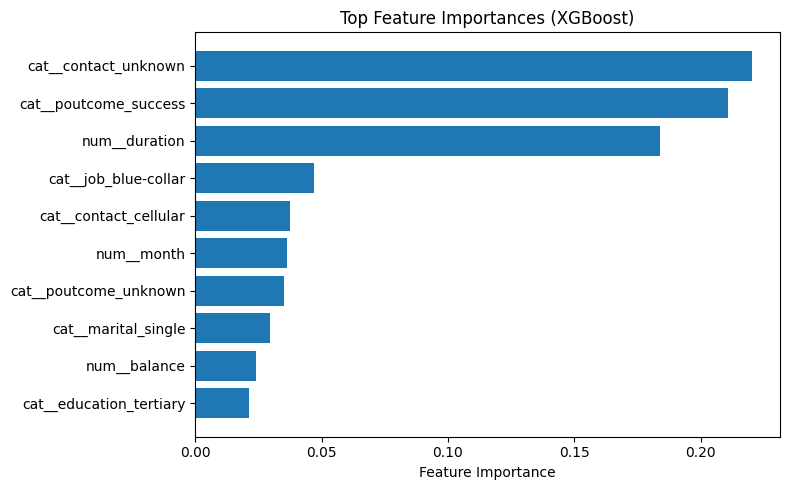

In [45]:
import matplotlib.pyplot as plt

# sort for plotting
fi_plot = fi.sort_values(by='importance', ascending=True)

plt.figure(figsize=(8, 5))
plt.barh(fi_plot['feature'], fi_plot['importance'])
plt.xlabel("Feature Importance")
plt.title("Top Feature Importances (XGBoost)")
plt.tight_layout()
plt.show()


The most important features are related to contact strategy and previous
campaign outcomes, indicating that client interaction history plays a
critical role in subscription prediction.

## Final Conclusion

In this project, a complete end-to-end machine learning pipeline was developed
to solve a binary classification problem from the Kaggle Playground Series
(Season 5, Episode 8). The objective was to predict the probability that a bank
client would subscribe to a term deposit using demographic, financial, and
campaign-related features.

A leakage-free preprocessing pipeline was implemented using
`ColumnTransformer` and `Pipeline`, followed by an XGBoost classifier with
explicit handling of class imbalance via `scale_pos_weight`. Model performance
was evaluated primarily using ROC–AUC, which is more appropriate than accuracy
for imbalanced classification tasks.

The baseline XGBoost model achieved strong generalization, with a public
leaderboard score of **0.95979** and a private leaderboard score of **0.95871**.
Subsequent hyperparameter tuning using Stratified K-Fold cross-validation
resulted in comparable performance and improved stability, achieving a public
score of **0.95965** and a private score of **0.95873**.

Feature importance analysis revealed that contact strategy, previous campaign
outcomes, and call duration were the most influential factors in predicting
client subscription behavior. These insights align well with real-world banking
and marketing intuition.

Overall, this project demonstrates a robust and well-validated approach to
large-scale tabular classification, combining sound preprocessing, appropriate
metric selection, careful model tuning, and clear interpretability. Future work
could include SHAP-based explanations, cost-sensitive threshold optimization,
and advanced ensembling techniques.
